Checking whether dark dresses could be observed at earth-based interferometers.

In [7]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from typing import Callable, Dict, Tuple

import jax
import jax.numpy as jnp
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar, root_scalar
from tqdm.auto import tqdm

from pydd.binary import *
from pydd.analysis import *

rho_s_pbh = 1.798e4 * MSUN / PC ** 3
gamma_s_pbh = 9 / 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def load_S_n(filename):
    _fs, _sqrt_S_ns = np.loadtxt(filename, unpack=True)
    idxs = jnp.where(~jnp.isnan(_sqrt_S_ns))[0]
    return jax.jit(lambda f: jnp.interp(f, _fs, _sqrt_S_ns ** 2, jnp.inf, jnp.inf)), (
        _fs[idxs[0]],
        _fs[idxs[-1]],
    )


S_n_aLIGO, f_range_aLIGO = load_S_n("data/aLIGO.dat")
S_n_ce, f_range_ce = load_S_n("data/ce.dat")
S_n_et, f_range_et = load_S_n("data/et.dat")

Check how characteristic strain of signal scales with frequency compared to noise. (See sec. 2.2 of [this paper](https://arxiv.org/pdf/1408.0740.pdf) for its definition.)

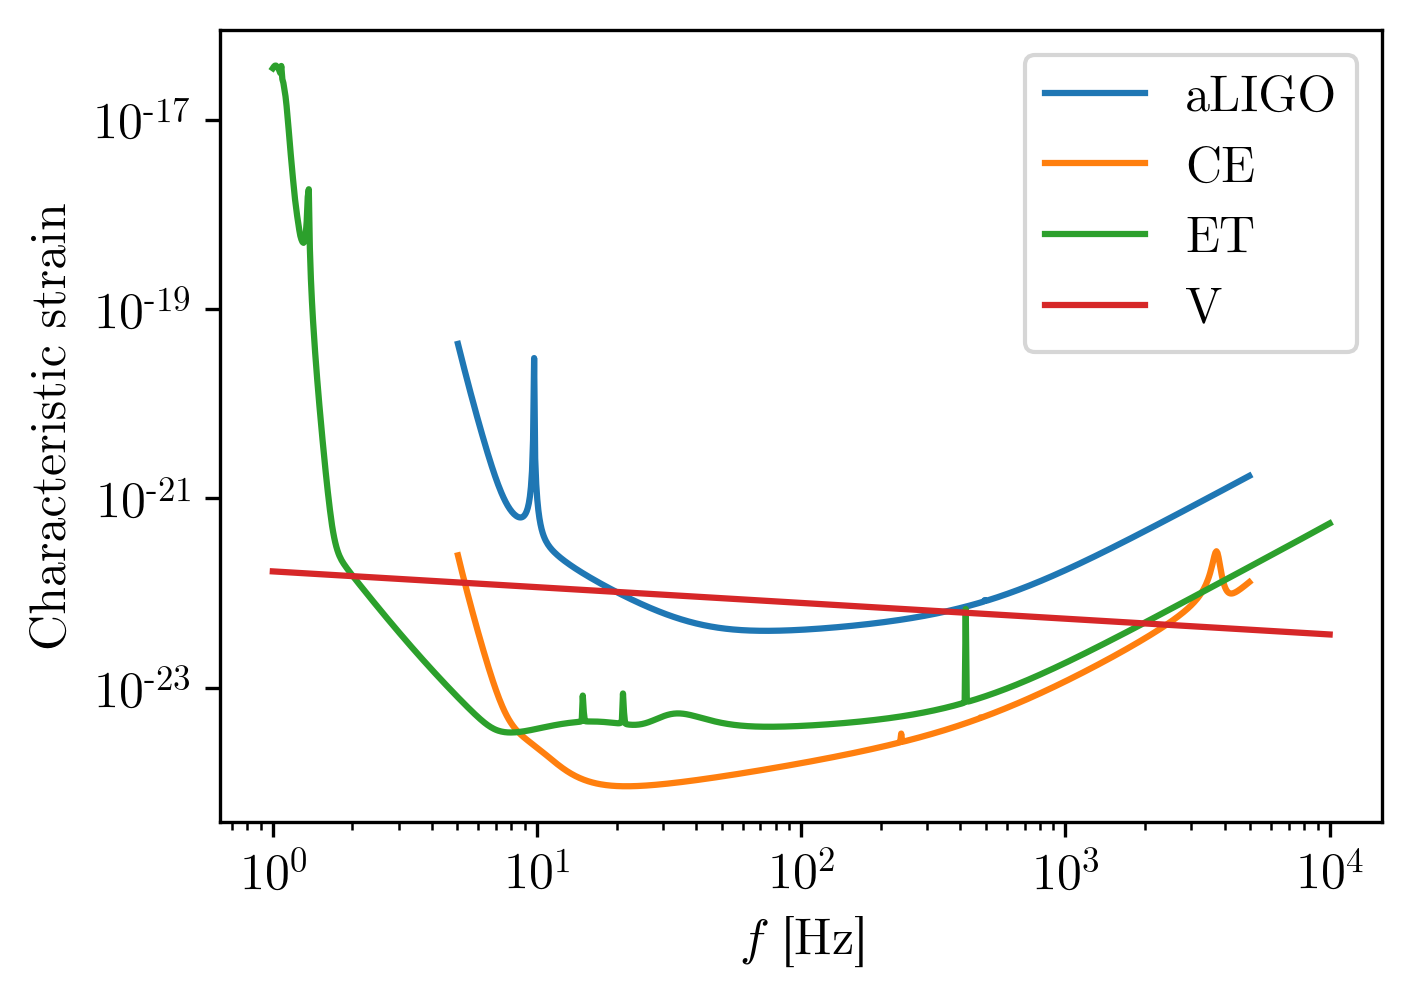

In [202]:
fs = jnp.geomspace(1, 1e4, 1000)
vb = make_vacuum_binary(5 * MSUN, 5e-3 * MSUN)

plt.plot(fs, jnp.sqrt(fs * S_n_aLIGO(fs)), label="aLIGO")
plt.plot(fs, jnp.sqrt(fs * S_n_ce(fs)), label="CE")
plt.plot(fs, jnp.sqrt(fs * S_n_et(fs)), label="ET")
plt.plot(fs, 2 * fs * amp(fs, vb), label="V")

plt.xlabel(r"$f$ [Hz]")
plt.ylabel("Characteristic strain")
plt.loglog();
plt.legend()

In [5]:
S_n_aLIGO(0.1)

DeviceArray(inf, dtype=float64)

In [6]:
f_range_aLIGO

(5.0, 5000.0)

In [21]:
results.keys()

dict_keys(['m_1_mg', 'm_2_mg', 'dL', 'f_h', 't_to_h', 'N_to_h', 'snr', 'dN_naive', 'M_chirp_MSUN', 'M_chirp_MSUN_v', 'snr_loss_frac', 'dN'])

In [198]:
def get_statistics(
    m_1: float,
    m_2: float,
    S_n: Callable[[jnp.ndarray], jnp.ndarray],
    f_range: Tuple[float, float],
    rho_s: float = rho_s_pbh,
    gamma_s: float = gamma_s_pbh,
    snr_thresh: float = 12,
) -> Dict[str, jnp.ndarray]:
    """
    Computes statistcs for dark dresses around PBHs.
    
    Arguments
    - m_1, m_2: black hole masses [kg]
    - S_n: noise PSD
    - f_range: support of S_n
    - rho_s, gamma_s: initial spike parameters. Default to PBH ones.
    - snr_thresh: target SNR. Used to compute distance to binary.
    
    Returns
    A dict with the following quantities:
    - dL: distance such that the system has the target SNR.
    - f_h: the smaller of max(f_range) and the binary's chirp frequency.
    - t_to_h: the time the system spends in band/before merging.
    - N_to_h: the number of GW cycles while the system is in band/before merging
    - snr: system's SNR. This is redundant, since it's just `snr_thresh`.
    - dN_naive: dephasing between system with and without dress between
      `f_range[0]` and `f_h`.
    - dN: dephasing between dark dress and best-fit vacuum system between
      `f_range[0]` and `f_h`.
    - M_chirp_MSUN: dark dress' chirp mass [MSUN].
    - M_chirp_MSUN_v: best-fit vacuum binary's chirp mass [MSUN].
    - snr_loss_frac: fraction of SNR lost by using vacuum template to search
      for the dark dress.
    """
    result = defaultdict(lambda: jnp.nan)
    if m_2 / m_1 > 10 ** (-2.5):
        return result

    f_l = f_range[0]

    # Find dL giving the correct SNR
    def fun(x):
        dd = make_dynamic_dress(m_1, m_2, rho_s, gamma_s, dL=x)
        f_h = min(dd.f_c, f_range[1])
        return calculate_SNR(dd, f_l, f_h, 1000, S_n) - snr_thresh

    res = root_scalar(fun, bracket=(0.1e6 * PC, 100000e6 * PC))
    assert res.converged
    result["dL"] = res.root

    dd = make_dynamic_dress(m_1, m_2, rho_s, gamma_s, dL=result["dL"])
    f_h = min(dd.f_c, f_range[1])
    vb_0 = convert(dd, VacuumBinary)

    # Basic information
    result["f_h"] = f_h
    result["t_to_h"] = t_to_c(f_l, dd) - t_to_c(f_h, dd)
    result["N_to_h"] = (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd)) / (2 * pi)
    result["snr"] = calculate_SNR(dd, f_l, f_h, 1000, S_n)
    result["dN_naive"] = (
        Phi_to_c(f_l, vb_0)
        - Phi_to_c(f_h, vb_0)
        - (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd))
    ) / (2 * pi)

    # Get best-fit vacuum system
    def fun(x):
        vb = VacuumBinary(x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
        nll = -loglikelihood_fft(vb, dd, f_l, f_h, 10000, 1000, S_n)
        return nll

    bracket = (dd.M_chirp / MSUN, dd.M_chirp / MSUN * (1 + 5e-3))
    res = minimize_scalar(fun, bracket=bracket, tol=1e-100)
    assert res.success
    #     assert bracket[0] < res.x and bracket[1] > res.x
    vb = VacuumBinary(res.x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)

    result["M_chirp_MSUN"] = dd.M_chirp / MSUN
    result["M_chirp_MSUN_v"] = res.x
    match = calculate_match_unnormd_fft(vb, dd, f_l, f_h, 10000, S_n)
    result["snr_loss_frac"] = jnp.clip(
        (result["snr"] - jnp.sqrt(match)) / result["snr"], 0
    )
    result["dN"] = (
        Phi_to_c(f_l, vb) - Phi_to_c(f_h, vb) - (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd))
    ) / (2 * pi)

    return result

In [238]:
# Run analysis
m_1_g = jnp.geomspace(1 * MSUN, 100 * MSUN, 40)
m_2_g = jnp.geomspace(1e-3 * MSUN, 5e-1 * MSUN, 38)
m_1_mg, m_2_mg = jnp.meshgrid(m_1_g, m_2_g)
m_1s, m_2s = m_1_mg.flatten(), m_2_mg.flatten()

results = []
for (m_1, m_2) in tqdm(list(zip(m_1s, m_2s))):
    results.append(get_statistics(m_1, m_2, S_n_et, f_range_et))

results = {
    k: jnp.array([r[k] for r in results]).reshape((len(m_2_g), len(m_1_g)))
    for k in results[0]
}

  0%|          | 0/1520 [00:00<?, ?it/s]

In [239]:
# jnp.savez("outputs/et.npz", m_1_mg=m_1_mg, m_2_mg=m_2_mg, **results)

Plot the results! Change the cell below as well as the contour levels to whatever you want.

In [19]:
# Load
results = {k: jnp.array(v) for k, v in dict(jnp.load("outputs/et.npz")).items()}
title = "Einstein Telescope"
plot_name = "figures/et.pdf"

<ipython-input-245-3f20b65fbe96>:14: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(


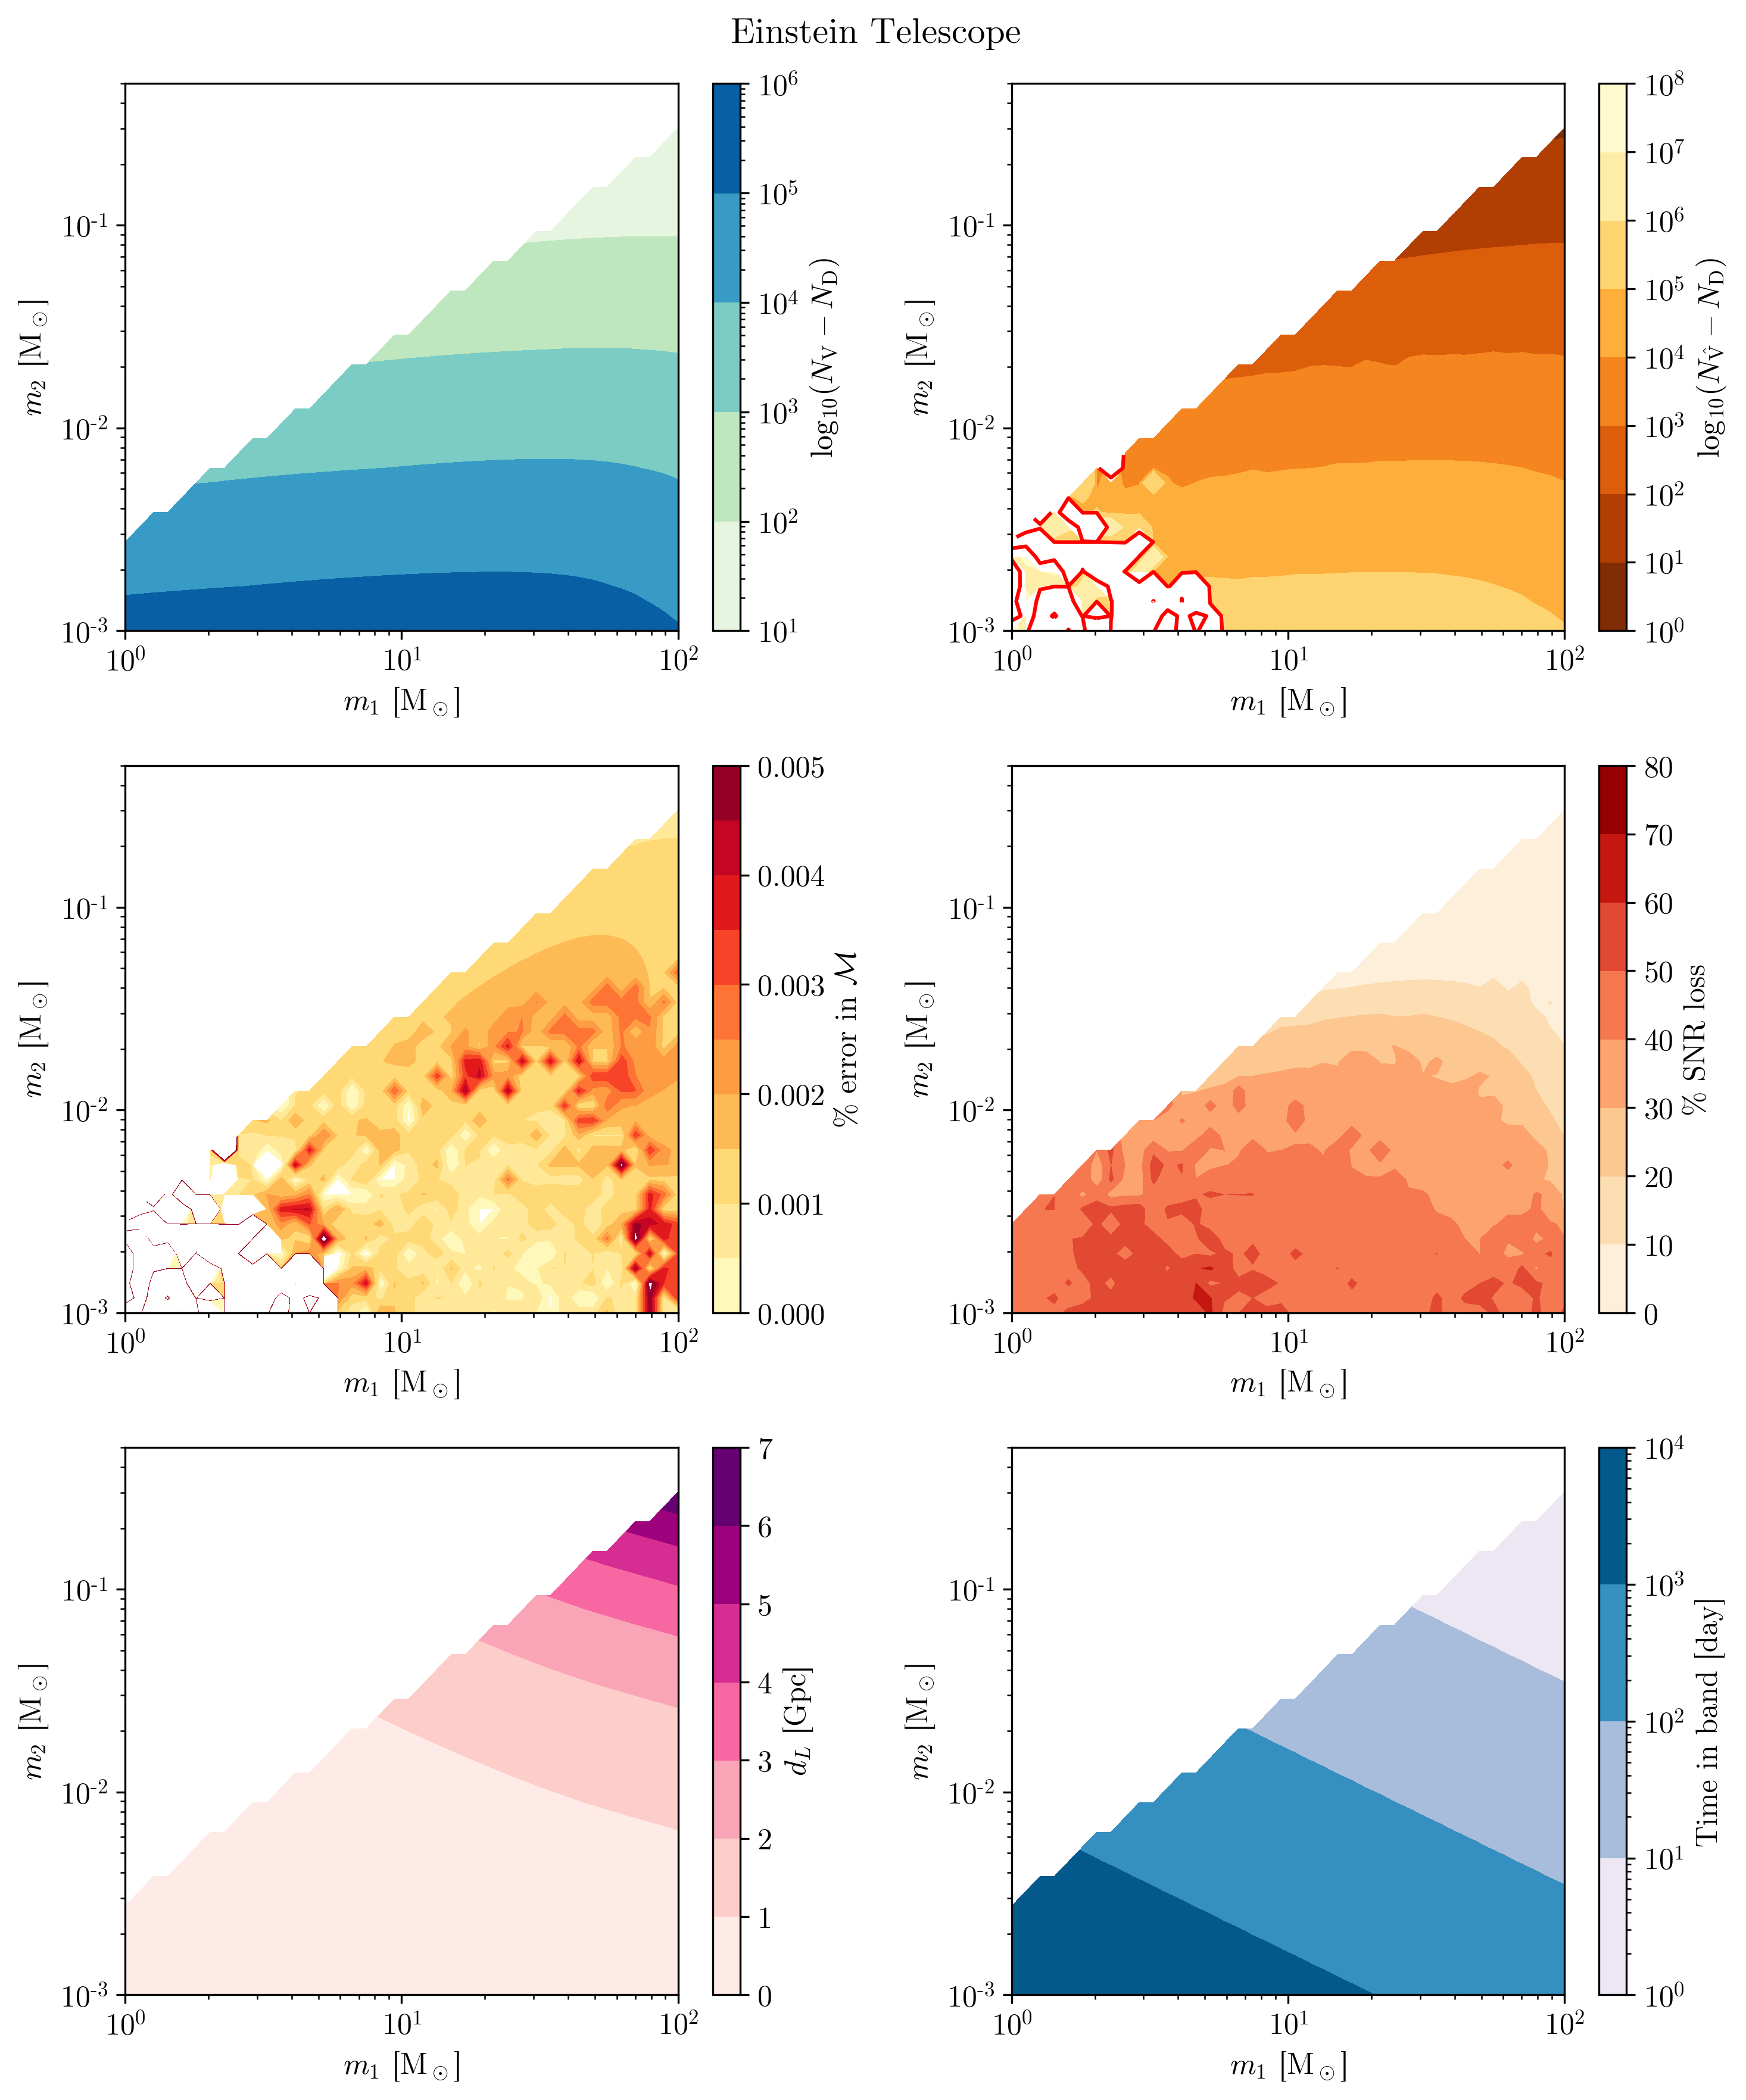

In [245]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

ax = axes[0, 0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["dN_naive"],
    locator=ticker.LogLocator(),
    cmap="GnBu",
)
plt.colorbar(cs, ax=ax, label=r"$\log_{10} (N_\mathrm{V} - N_\mathrm{D})$")

ax = axes[0, 1]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["dN"],
    locator=ticker.LogLocator(),
    cmap="YlOrBr_r",
)
plt.colorbar(cs, ax=ax, label=r"$\log_{10} (N_\hat{\mathrm{V}} - N_\mathrm{D})$")
ax.contour(m_1_g / MSUN, m_2_g / MSUN, results["dN"], [1], colors=["r"])

ax = axes[1, 0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    (results["M_chirp_MSUN_v"] - results["M_chirp_MSUN"])
    / results["M_chirp_MSUN"]
    * 100,
    levels=jnp.linspace(0, 0.005, 11),
    cmap="YlOrRd",
)
plt.colorbar(cs, ax=ax, label=r"% error in $\mathcal{M}$")

ax = axes[1, 1]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["snr_loss_frac"] * 100,
    levels=jnp.linspace(0, 80, 9),
    cmap="OrRd",
)
plt.colorbar(cs, ax=ax, label="% SNR loss")

ax = axes[2, 0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["dL"] / (1e9 * PC),
    levels=jnp.linspace(0, 7, 8),
    cmap="RdPu",
)
plt.colorbar(cs, ax=ax, label=r"$d_L$ [Gpc]")

ax = axes[2, 1]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["t_to_h"] / (24 * 60**2),
    cmap="PuBu",
#     levels=jnp.linspace(0, 2e3, 11),
    locator=ticker.LogLocator(),
)
plt.colorbar(cs, ax=ax, label="Time in band [day]")

for ax in axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$m_1$ [M$_\odot$]")
    ax.set_ylabel(r"$m_2$ [M$_\odot$]")

fig.tight_layout()
fig.suptitle(title)
# plt.savefig(plot_name)

### Check whether fits are reliable or too unstable. They look pretty reasonable, even for quite large dephasings.

In [243]:
dd = make_dynamic_dress(40 * MSUN, 1e-2 * MSUN, rho_s_pbh, gamma_s_pbh, dL=120e6 * MSUN)


def fun(M_chirp_MSUN):
    vb = VacuumBinary(M_chirp_MSUN * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
    f_h = min(dd.f_c, f_range_et[1])
    return loglikelihood_fft(vb, dd, f_range_et[0], f_h, 10000, 1000, S_n_et)

bracket = (dd.M_chirp / MSUN * (1 - 1e-5), dd.M_chirp / MSUN * (1 + 5e-5))
M_chirp_MSUNs = jnp.linspace(*bracket, 200)
lls = jnp.array([fun(Mc) for Mc in M_chirp_MSUNs])

vb = VacuumBinary(
    M_chirp_MSUNs[jnp.argmax(lls)] * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c
)
f_l, f_h = f_range_et[0], min(f_range_et[1], dd.f_c)
print(
    "dN = ",
    (Phi_to_c(f_l, vb) - Phi_to_c(f_h, vb) - (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd)))
    / (2 * pi),
)

dN =  5024.558084326916


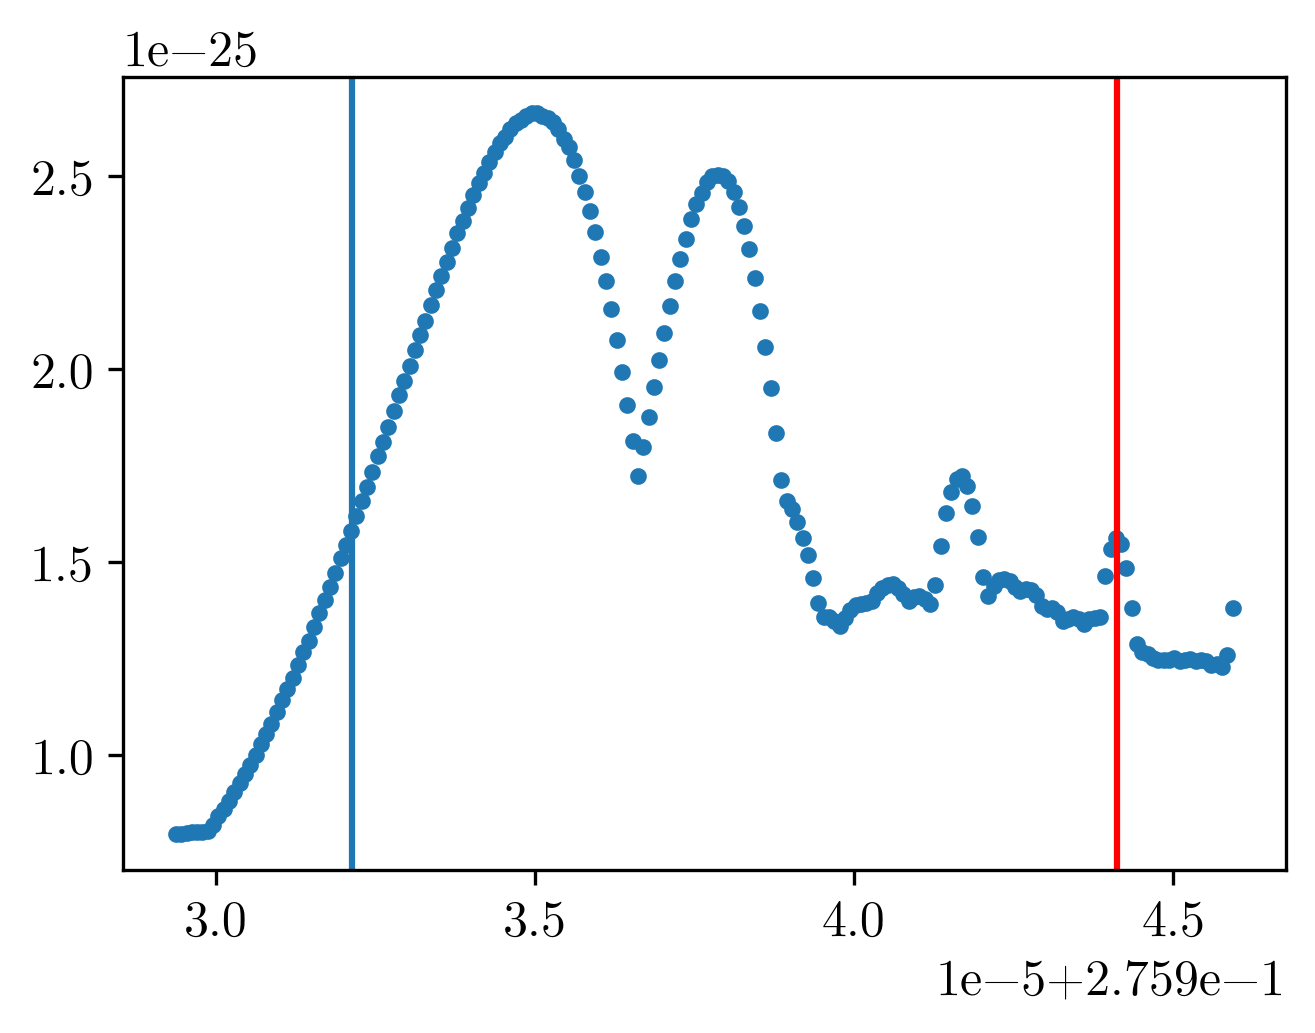

In [244]:
plt.plot(M_chirp_MSUNs, lls, ".")
plt.axvline(dd.M_chirp / MSUN)
plt.axvline(minimize_scalar(lambda x: -fun(x), bracket).x, color="r")

## Density normalization

In [105]:
def get_rho_6T(m_1, rho_s=1.798e4 * MSUN / PC ** 3):
    fun = lambda rho_6T: get_rho_s(rho_6T * 1e16 * MSUN / PC ** 3, m_1, 9 / 4) - rho_s
    return root_scalar(fun, bracket=(1e-6, 1e1)).root

Text(0.5, 1.0, 'PBH dress density normalization')

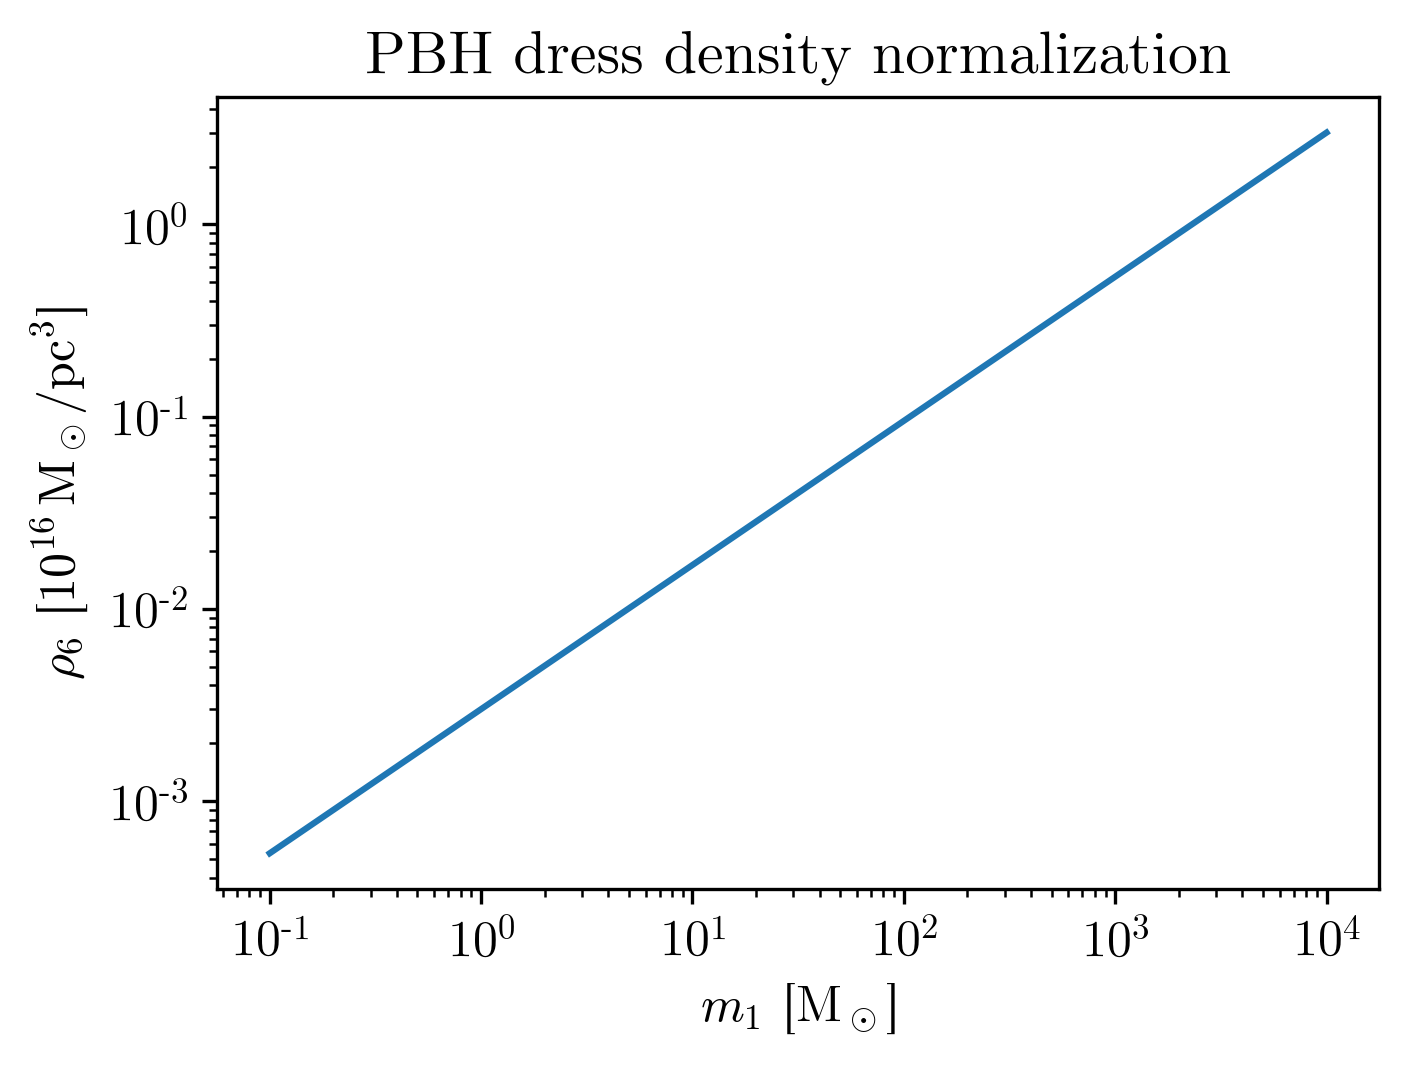

In [113]:
m_1s = jnp.geomspace(1e-1 * MSUN, 1e4 * MSUN, 100)

plt.loglog(m_1s / MSUN, list(map(get_rho_6T, m_1s)))
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$\rho_6$ [$10^{16} \, \mathrm{M}_\odot / \mathrm{pc}^3$]")
plt.title("PBH dress density normalization")

## Old

In [65]:
print("SNR = ", calculate_SNR(dd, f_l, dd.f_c, 3000, S_n))
print("dPhi (naive) = ", (Phi_to_c(f_l, vb_0) - Phi_to_c(f_l, dd)) / (2 * pi))

SNR =  14.991045811241946
Naive dephasing =  -5.229407663098171


Find best-fit vacuum system

In [14]:
dd = make_dynamic_dress(
    5 * MSUN, 5e-3 * MSUN, 1.798e4 * MSUN / PC ** 3, 9 / 4, dL=26e6 * PC
)
f_l = 20.0

In [69]:
def fun(x):
    vb = VacuumBinary(x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
    return -loglikelihood_fft(vb, dd, f_l, dd.f_c, 5000, 1000, S_n)


res = minimize_scalar(fun, bracket=(dd.M_chirp / MSUN, dd.M_chirp / MSUN + 1e-4), tol=1e-100)
assert res.success
vb = VacuumBinary(res.x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
print("p(h|s) = ", -res.fun)
print("p(s|s) = ", loglikelihood_fft(dd, dd, f_l, dd.f_c, 5000, 1000, S_n))
print("Dephasing = ", (Phi_to_c(f_l, vb) - Phi_to_c(f_l, dd)) / (2 * pi), " cycle")

p(h|s) =  71.7761575459551
p(s|s) =  112.47968507665817
Dephasing =  -1.215834026833111  cycle


Text(0, 0.5, 'Match integrand [s?]')

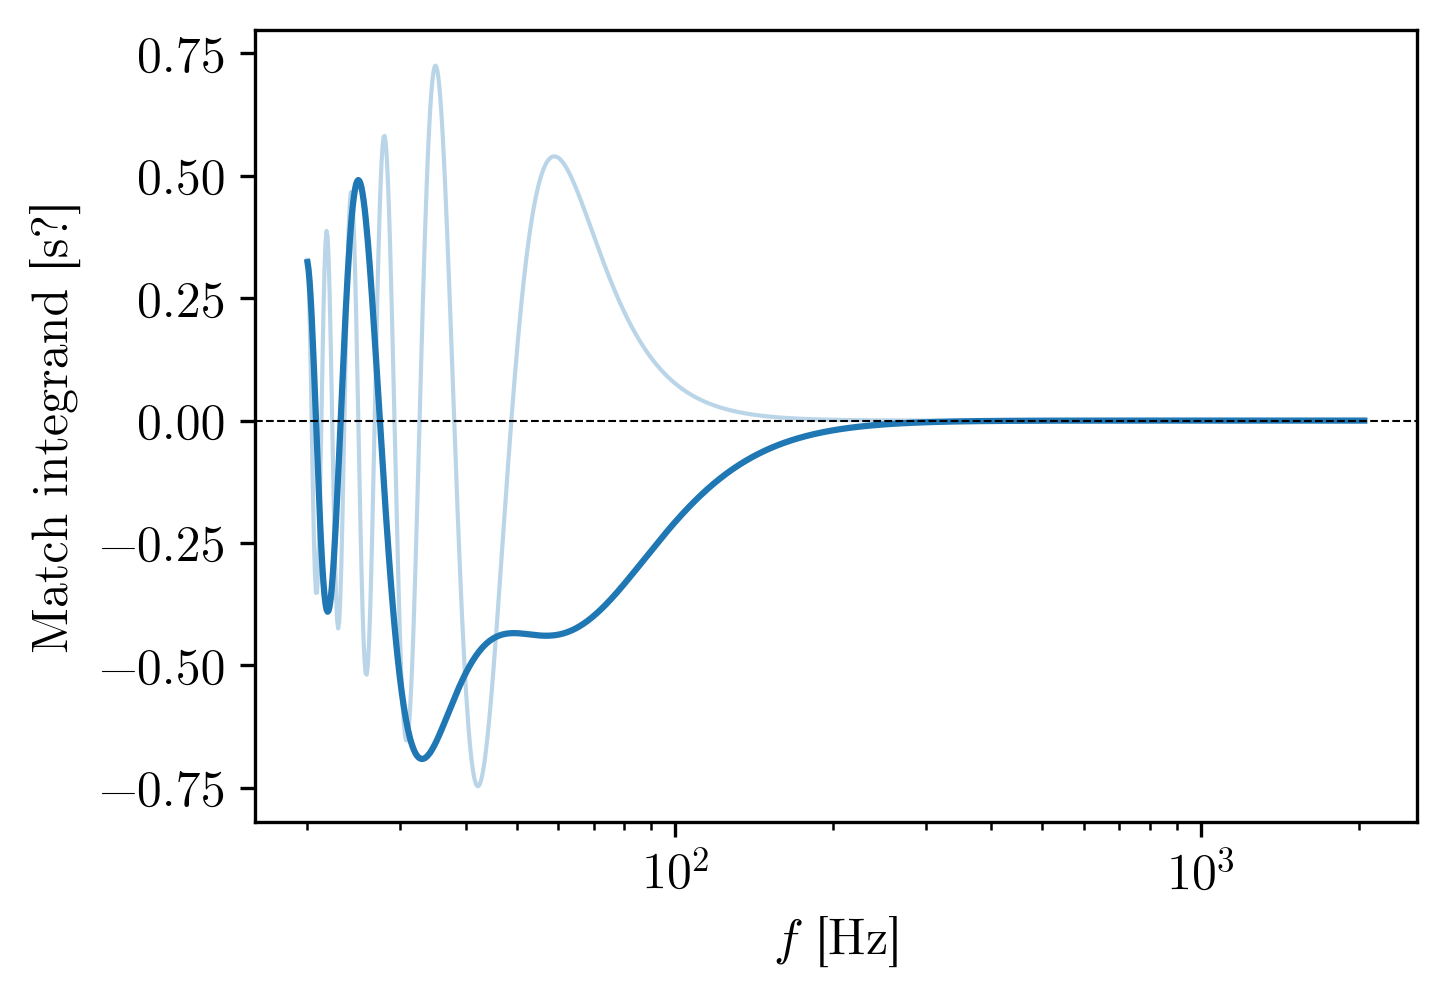

In [29]:
plt.semilogx(
    fs, amp(fs, vb) * amp(fs, dd) * jnp.sin(Phi_to_c(fs, vb) - Phi_to_c(fs, dd)) / S_n(fs)
)
# plt.semilogx(
#     fs, amp(fs, vb) * amp(fs, dd) * jnp.cos(Phi_to_c(fs, vb) - Phi_to_c(fs, dd)) / S_n(fs)
# )

plt.semilogx(
    fs,
    amp(fs, vb_0) * amp(fs, dd) * jnp.sin(Phi_to_c(fs, vb_0) - Phi_to_c(fs, dd)) / S_n(fs),
    "C0",
    alpha=0.3,
    linewidth=1
)
# plt.semilogx(
#     fs,
#     amp(fs, vb_0) * amp(fs, dd) * jnp.cos(Phi_to_c(fs, vb_0) - Phi_to_c(fs, dd)) / S_n(fs),
#     "C1",
#     alpha=0.3,
#     linewidth=1
# )

plt.axhline(0, linestyle="--", color="k", linewidth=0.5)
plt.xlabel(r"$f$ [Hz]")
plt.ylabel("Match integrand [s?]")

## Scratch

Text(0, 0.5, 'Strain')

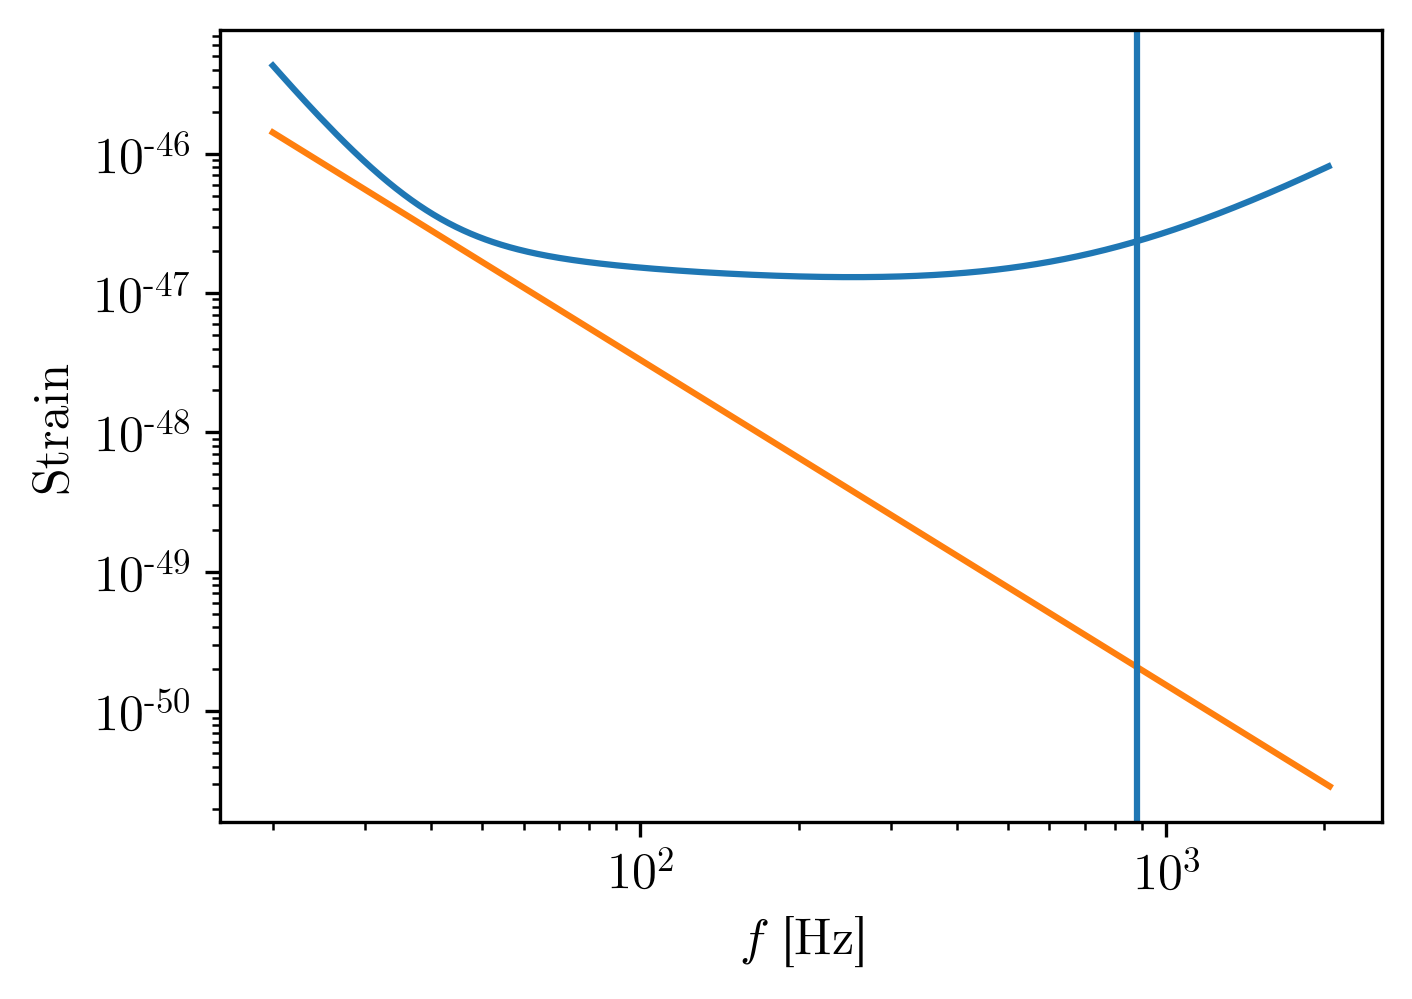

In [155]:
plt.loglog(fs, S_n(fs))
plt.loglog(fs, amp(fs, dd) ** 2)
plt.axvline(dd.f_c)
plt.xlabel(r"$f$ [Hz]")
plt.ylabel("Strain")

In [148]:
vb = VacuumBinary(0.079231 * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
print("p(h|s) = ", loglikelihood_fft(vb, dd, f_l, dd.f_c, 5000, 1000, S_n))
print("p(s|s) = ", loglikelihood_fft(dd, dd, f_l, dd.f_c, 5000, 1000, S_n))
print("Dephasing = ", (Psi(f_l, vb) - Psi(f_l, dd)) / (2 * pi), " cycle")

p(h|s) =  14.498258565576357
p(s|s) =  112.47968507665817
Dephasing =  -2.995448516048727  cycle
